In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [281]:
data = pd.read_csv('Sorghum_Hyperspectral_Data_1820.csv')

C:\Users\Deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [282]:
data.head()

,crop,PlotID,year,trt,pheno,CHL,EWT,LWC,SLA,N,...,X2491,X2492,X2493,X2494,X2495,X2496,X2497,X2498,X2499,X2500
0,sorghum,281,2018,greenhouse,yes,446.944,0.021140,0.801818,191.380472,2.84,...,0.057221,0.057268,0.057137,0.056709,0.056457,0.056115,0.055923,0.055987,0.055888,0.055737
1,sorghum,282,2018,greenhouse,yes,713.800,0.013651,0.718788,187.244828,3.44,...,0.065625,0.065636,0.065593,0.065518,0.065329,0.065109,0.064884,0.064390,0.064180,0.064182
2,sorghum,283,2018,greenhouse,yes,724.911,0.013870,0.715429,181.260442,3.52,...,0.061687,0.061462,0.061244,0.061186,0.060975,0.060398,0.060287,0.060618,0.060535,0.060500
3,sorghum,284,2018,greenhouse,yes,738.400,0.016723,0.753034,182.327753,4.13,...,0.055341,0.055124,0.054997,0.055162,0.055078,0.054760,0.054617,0.054473,0.054353,0.054351
4,sorghum,285,2018,greenhouse,yes,700.344,0.023406,0.798125,168.909288,3.85,...,0.056971,0.057206,0.057154,0.056835,0.056743,0.056700,0.056552,0.056538,0.056412,0.056039


In [283]:
data.year.value_counts(dropna= False)

2020    1470
2018     321
Name: year, dtype: int64

In [284]:
data.shape

(1791, 2171)

In [285]:
data.columns[1:50]

Index(['PlotID', 'year', 'trt', 'pheno', 'CHL', 'EWT', 'LWC', 'SLA', 'N', 'P',
       'K', 'Mg', 'Ca', 'S', 'Fe', 'Mn', 'B', 'Cu', 'Zn', 'X350', 'X351',
       'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360',
       'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369',
       'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378',
       'X379'],
      dtype='object')

In [286]:
data.loc[data.year == 2018 , 'trt'].value_counts(dropna = False)

greenhouse    321
Name: trt, dtype: int64

In [287]:
#define the trait for analysis
trait = 'S'


In [288]:
#Drop NAs 
data = data.loc[data[trait].notnull(), :]
#data1 = data[data.SLA.notnull()]
data.shape

(587, 2171)

<AxesSubplot:xlabel='year', ylabel='S'>

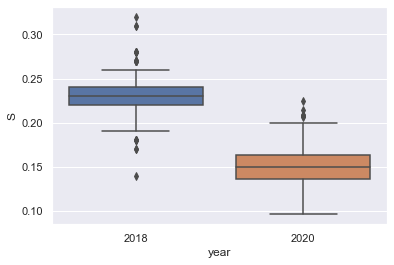

In [289]:
sns.boxplot(y= trait, x='year', data=data)

In [290]:
#defining a function to remove the outliers
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1=datacolumn.quantile(0.25)
 Q3=datacolumn.quantile(0.75)
 #Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [291]:
outlier_treatment(data[trait])


(0.03749999999999998, 0.34550000000000003)

In [292]:
lowerbound,upperbound = outlier_treatment(data[trait])

In [293]:
rm_index =data[(data[trait] < lowerbound) | (data[trait] > upperbound)].index
rm_index

Int64Index([], dtype='int64')

In [294]:
data.drop(rm_index, axis=0 ,inplace=True)

In [295]:
# choose the years for grouping in the plots
year = data.loc[: , 'year']

In [296]:
data.shape


(587, 2171)

In [297]:
# define trait data
y = data.loc[: , trait]


In [298]:
#select the columns of HR data
spec_columns = [col for col in data if col.startswith('X')]


In [299]:
# Define the X by choosing only the predictors
X = data[spec_columns]


In [300]:
# Apply Savitzky Golay Filter
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns= spec_columns)

In [301]:
# Remove first 100 wawelengths
X = X.drop(X.columns[0:100], axis=1)

In [302]:
# Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [303]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]

In [304]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size=0.4) 

In [305]:
regressor = RandomForestRegressor(2000) #, min_samples_split=5 , min_samples_leaf= 1 , max_features= 'auto' , max_depth =90 , bootstrap = True)
predict = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [306]:
y_pred = regressor.predict(X_test)

In [307]:
y_pred = pd.DataFrame(y_pred)

In [308]:
# Combine the 'year' and y_test for plotting and reset the index for combining with y_pred
y_test =pd.merge(y_test, year , left_index=True , right_index=True,  how='left').reset_index(drop=True)

In [309]:
y_test.head()

,S,year
0,0.230,2018
1,0.230,2018
2,0.155,2020
3,0.120,2020
4,0.270,2018


In [310]:
type(y_pred)

pandas.core.frame.DataFrame

In [311]:
#Combine y_test and y_pred and get one data frame for seaborn scatter plot
data_plot = pd.concat([y_test, y_pred], axis = 1)

In [312]:
data_plot =data_plot.rename({0 : 'predicted'} ,axis =1)

In [313]:
data_plot.head()

,S,year,predicted
0,0.230,2018,0.230740
1,0.230,2018,0.232221
2,0.155,2020,0.174167
3,0.120,2020,0.132532
4,0.270,2018,0.233685


In [314]:
# Calculate the spearman correlation , r2 and p value and pass them into the 'text'

from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in data_plot.predicted]
r, p = spearmanr(data_plot[trait], data_plot.predicted)
r2 = r**2
text =r2, p
text = [np.round(r2, 2) for r2 in text]


Text(0.5, 1.0, 'S RF')

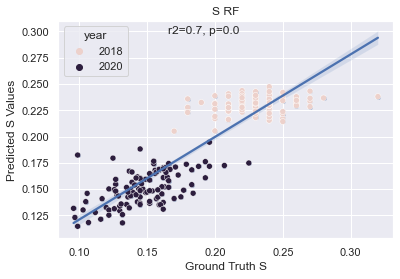

In [315]:
#plot the results
text1 = 'r2=%s, p=%s' % (text[0], text[1])
#sns.lmplot(x=trait, y='predicted',data=data_plot)
sns.regplot(x=trait, y='predicted' , scatter_kws={'s' : 15},data=data_plot)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x=trait, y='predicted', hue= 'year', data=data_plot).text((xmax)/2, ymax*0.96, text1, fontsize=12)
plt.xlabel('Ground Truth' + ' ' + trait)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'Values')
plt.title(trait + ' ' + 'RF')



# Feature Importance
from sklearn.inspection import permutation_importance
result = permutation_importance(regressor, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index = X_train.columns)

In [316]:
#forest_importances.sort_values(ascending=False,inplace=True)

In [317]:
#most_important = forest_importances[0:300]

In [318]:
#most_important = pd.DataFrame(most_important)

In [319]:
#most_important

In [320]:
#most_important_index = pd.Series(most_important.index)
#most_important_index

In [321]:
#most_important_index.to_csv('most_important_index.csv')

In [322]:
#X_reduced = X.loc[: , most_important_index]

In [323]:
# split the dataset into training (60%) and testing (40%) sets
#X_train,X_test,y_train,y_test = train_test_split(X_reduced, y ,test_size=0.4) 

In [324]:
#regressor = RandomForestRegressor(2000) #, min_samples_split=5 , min_samples_leaf= 1 , max_features= 'auto' , max_depth =90 , bootstrap = True)
#predict = regressor.fit(X_train, y_train)
#y_pred = regressor.predict(X_test)

In [325]:
#np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))

In [326]:
#y_pred = regressor.predict(X_test)

In [327]:
#plt.scatter(y_test, y_pred)
#plt.ylabel('Predicted' + ' ' + trait +  ' ' 'values')
#plt.xlabel('Ground truth LWC measurements')
#sns.regplot(x = y_test , y = y_pred)

In [328]:
#from scipy.stats import pearsonr, spearmanr

#r, p = spearmanr(y_test, y_pred)
#r2 = r**2
#print(r2, p)

In [329]:
data_2022 = pd.read_csv('sorghum_2022_whole.csv')

In [330]:
data_2022 = data_2022.loc[data_2022['355'].notnull(), :]

In [331]:
data_2022['CHL'] = data_2022[['CHLp1', 'CHLp2']].mean(axis=1)

In [332]:
#data_2022 = data_2022.loc[data_2022['Leaf_num'] == 2 , :]

In [333]:
#data_2022 = data_2022.loc[data_2022['Leaf_pos'] == 2 , :]

In [334]:
data_2022 = data_2022.loc[data_2022['355']>0 , :]
data_2022.head()

,Date Recd,Date Rept,Genotype,Rep,Sample ID,P,K,S,Ca,Mg,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,CHL
0,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.071300,0.0707,0.0698,0.069483,0.07050,0.0701,0.0685,0.0683,0.0684,420.15
1,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.074300,0.0740,0.0743,0.074400,0.07416,0.0736,0.0724,0.0726,0.0741,420.15
2,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.061000,0.0605,0.0597,0.059500,0.05930,0.0587,0.0582,0.0582,0.0580,420.15
3,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.075948,0.0754,0.0729,0.072100,0.07200,0.0717,0.0726,0.0726,0.0722,569.50
4,05/26/2022,05/28/2022,1,1,1-1,0.212,1.96,0.211,1.676,0.776,...,0.082870,0.0823,0.0813,0.080900,0.07990,0.0796,0.0812,0.0816,0.0816,569.50


In [335]:
import copy
data_test = copy.deepcopy(data_2022)


my_group = data_test.groupby(['Genotype', 'Rep', 'Leaf_num']).mean()

my_group.head()

P     K      S     Ca     Mg    Zn     Fe     Mn  \
Genotype Rep Leaf_num                                                         
1        1   1         0.212  1.96  0.211  1.676  0.776  79.0  196.0  139.0   
             2         0.212  1.96  0.211  1.676  0.776  79.0  196.0  139.0   
             3         0.212  1.96  0.211  1.676  0.776  79.0  196.0  139.0   
         2   1         0.273  2.17  0.204  1.237  0.614  66.0  150.0   94.0   
             2         0.273  2.17  0.204  1.237  0.614  66.0  150.0   94.0   

                         Cu     B  ...      2492      2493      2494  \
Genotype Rep Leaf_num              ...                                 
1        1   1         15.6  21.2  ...  0.068867  0.068400  0.067933   
             2         15.6  21.2  ...  0.072113  0.071661  0.069933   
             3         15.6  21.2  ...  0.081300  0.081133  0.081500   
         2   1         14.7  23.8  ...  0.096758  0.096511  0.096506   
             2         14.7  23.8  ...  0.065500  0.065067  0.064433   

                           2495      2496      2497      2498      2499  \
Genotype Rep Leaf_num                                                     
1        1   1         0.067794  0.067987  0.067467  0.066367  0.066367   
             2         0.069333  0.069033  0.068800  0.069767  0.069900   
             3         0.081195  0.080567  0.080167  0.078967  0.078567   
         2   1         0.096442  0.096699  0.096389  0.095690  0.095272   
             2         0.064229  0.064000  0.063740  0.064100  0.064033   

                           2500     CHL  
Genotype Rep Leaf_num                    
1        1   1         0.066833  420.15  
             2         0.069767  569.50  
             3         0.079233  400.75  
         2   1         0.094480  294.50  
             2         0.063400  403.10  

[5 rows x 2173 columns]

In [336]:
my_group = my_group.reset_index(level=['Leaf_num', 'Genotype', 'Rep'])
my_group.head() 

,Genotype,Rep,Leaf_num,P,K,S,Ca,Mg,Zn,Fe,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,CHL
0,1,1,1,0.212,1.96,0.211,1.676,0.776,79.0,196.0,...,0.068867,0.068400,0.067933,0.067794,0.067987,0.067467,0.066367,0.066367,0.066833,420.15
1,1,1,2,0.212,1.96,0.211,1.676,0.776,79.0,196.0,...,0.072113,0.071661,0.069933,0.069333,0.069033,0.068800,0.069767,0.069900,0.069767,569.50
2,1,1,3,0.212,1.96,0.211,1.676,0.776,79.0,196.0,...,0.081300,0.081133,0.081500,0.081195,0.080567,0.080167,0.078967,0.078567,0.079233,400.75
3,1,2,1,0.273,2.17,0.204,1.237,0.614,66.0,150.0,...,0.096758,0.096511,0.096506,0.096442,0.096699,0.096389,0.095690,0.095272,0.094480,294.50
4,1,2,2,0.273,2.17,0.204,1.237,0.614,66.0,150.0,...,0.065500,0.065067,0.064433,0.064229,0.064000,0.063740,0.064100,0.064033,0.063400,403.10


In [337]:
my_group.columns

Index(['Genotype', 'Rep', 'Leaf_num', 'P', 'K', 'S', 'Ca', 'Mg', 'Zn', 'Fe',
       ...
       '2492', '2493', '2494', '2495', '2496', '2497', '2498', '2499', '2500',
       'CHL'],
      dtype='object', length=2176)

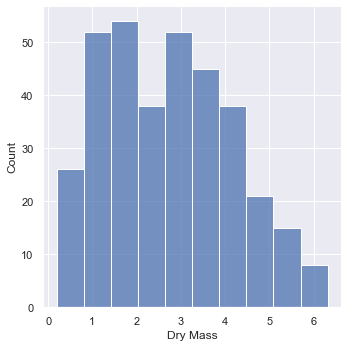

In [338]:
sns.set(style='darkgrid')
sns.displot(data= my_group, x = 'DW').set(xlabel = 'Dry Mass')


In [339]:
y_test = my_group.loc[:,trait]

In [340]:
X_total = my_group.iloc[:, 24:2175]

In [341]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [342]:
X_total

,450,451,452,453,454,455,456,457,458,459,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.043333,0.043743,0.043761,0.043844,0.044167,0.044267,0.044233,0.044367,0.044533,0.043800,...,0.069061,0.068867,0.068400,0.067933,0.067794,0.067987,0.067467,0.066367,0.066367,0.066833
1,0.067200,0.067733,0.067900,0.068167,0.068533,0.068133,0.068167,0.068467,0.068800,0.068700,...,0.071801,0.072113,0.071661,0.069933,0.069333,0.069033,0.068800,0.069767,0.069900,0.069767
2,0.080033,0.080467,0.080700,0.081233,0.081900,0.081867,0.081900,0.082167,0.082433,0.082200,...,0.081767,0.081300,0.081133,0.081500,0.081195,0.080567,0.080167,0.078967,0.078567,0.079233
3,0.120504,0.120188,0.120325,0.120911,0.121601,0.121789,0.121711,0.121736,0.122047,0.122260,...,0.097131,0.096758,0.096511,0.096506,0.096442,0.096699,0.096389,0.095690,0.095272,0.094480
4,0.069800,0.070333,0.069676,0.069300,0.069767,0.070333,0.070449,0.070524,0.070967,0.071167,...,0.065587,0.065500,0.065067,0.064433,0.064229,0.064000,0.063740,0.064100,0.064033,0.063400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0.049067,0.048667,0.048900,0.049264,0.049400,0.049650,0.050202,0.050433,0.050100,0.050333,...,0.068733,0.067667,0.067167,0.066733,0.066233,0.065900,0.065767,0.065648,0.065467,0.065735
345,0.056133,0.055800,0.056133,0.056733,0.057233,0.057541,0.057767,0.057833,0.057703,0.058200,...,0.071500,0.070788,0.070300,0.070133,0.069778,0.069367,0.069033,0.068767,0.068372,0.067833
346,0.051147,0.051020,0.051497,0.051967,0.052150,0.052233,0.052633,0.052900,0.052788,0.053000,...,0.057467,0.057233,0.056833,0.056100,0.055833,0.055567,0.055333,0.055933,0.055629,0.054000
347,0.046212,0.046233,0.046133,0.046500,0.047200,0.047300,0.047300,0.047167,0.047033,0.047467,...,0.058200,0.056667,0.056133,0.055433,0.055091,0.055762,0.055933,0.055966,0.055733,0.055077


In [343]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X_test= X_total.iloc[:, column_filter] # selecting the filtered columns 

In [344]:
X_test.columns = X.columns

In [345]:
#X_test = X_test.loc[: , most_important_index]

## Hyperparameter Grid Search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

## Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = RepeatedKFold(n_splits=10), verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

rf_random.best_params_

In [346]:
regressor = RandomForestRegressor(2000)#, min_samples_split=5 , min_samples_leaf= 2 , max_features= 'auto' , max_depth =90 , bootstrap = True)
predict = regressor.fit(X, y)
y_pred = regressor.predict(X_test)

In [347]:
np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))

0.03713918717261327

<AxesSubplot:xlabel='S', ylabel='Predicted CHL values'>

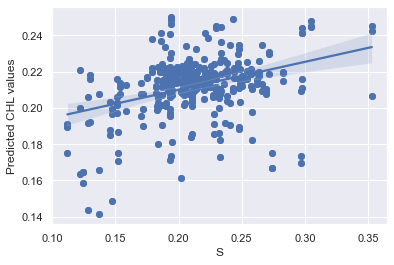

In [348]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted CHL values')
plt.xlabel('Ground truth SLA measurements')
sns.regplot(x = y_test , y = y_pred)


In [349]:
from scipy.stats import pearsonr, spearmanr

r, p = spearmanr(y_test, y_pred)
r2 = r**2
print(r2, p)

0.08229859307309602 4.892628071512636e-08


In [350]:
X_test

,X450,X455,X460,X465,X470,X475,X480,X485,X490,X495,...,X2450,X2455,X2460,X2465,X2470,X2475,X2480,X2485,X2490,X2495
0,0.043333,0.044267,0.043600,0.043867,0.044267,0.043900,0.044307,0.044467,0.045067,0.047426,...,0.091833,0.088533,0.085128,0.082247,0.079333,0.075700,0.074131,0.071467,0.069467,0.067794
1,0.067200,0.068133,0.068533,0.068898,0.068867,0.068800,0.069144,0.069633,0.070633,0.073176,...,0.094579,0.090923,0.088384,0.085367,0.082133,0.079633,0.077033,0.074800,0.072100,0.069333
2,0.080033,0.081867,0.082333,0.082933,0.083067,0.082667,0.083300,0.083733,0.084733,0.087400,...,0.102507,0.099832,0.096623,0.093904,0.091496,0.088257,0.086456,0.084069,0.082167,0.081195
3,0.120504,0.121789,0.122650,0.123799,0.124373,0.124767,0.125985,0.126306,0.128308,0.131741,...,0.118726,0.115274,0.112251,0.109472,0.107039,0.104346,0.102132,0.099334,0.097533,0.096442
4,0.069800,0.070333,0.070980,0.071412,0.071100,0.070933,0.071500,0.071600,0.073033,0.074800,...,0.086333,0.083233,0.079872,0.076933,0.075000,0.072133,0.070133,0.067867,0.065907,0.064229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,0.049067,0.049650,0.050500,0.050967,0.050667,0.050700,0.050936,0.051758,0.052433,0.054479,...,0.091359,0.087900,0.084867,0.081567,0.078600,0.074703,0.072467,0.070200,0.069046,0.066233
345,0.056133,0.057541,0.058315,0.058603,0.058133,0.058087,0.058233,0.058733,0.059888,0.062400,...,0.095155,0.091603,0.088067,0.084156,0.081700,0.077967,0.075267,0.073733,0.072000,0.069778
346,0.051147,0.052233,0.052933,0.053200,0.053043,0.053267,0.053170,0.054000,0.054695,0.056841,...,0.077933,0.074767,0.071676,0.068767,0.066167,0.064000,0.061173,0.059833,0.057614,0.055833
347,0.046212,0.047300,0.047433,0.047883,0.047333,0.047333,0.047733,0.047954,0.048533,0.050400,...,0.077815,0.074833,0.071567,0.068633,0.065600,0.063395,0.061231,0.058867,0.058333,0.055091
